In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Embeddings_UKB= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/epilepsy_PBS/Embeddings.csv")

In [3]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [4]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [5]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})
Embeddings_UKB  = Embeddings_UKB.rename(columns={Embeddings_UKB.columns[0]: "Index"})

In [6]:
mask= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/mask_interrupted_cs.csv")

In [7]:
mask=np.array(mask)

In [8]:
mask =mask.flatten()

In [9]:
Embeddings_interrupted_cs= Embeddings_UKB[mask]
Embeddings_UKB= Embeddings_UKB[~mask]

In [10]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
Embeddings_irm_negatives = Embeddings_epilepsy.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
Embeddings_irm_positives = Embeddings_epilepsy.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

In [11]:
X1 = Embeddings_UKB.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_irm_negatives.iloc[:,1:76]
X5= Embeddings_irm_positives.iloc[:,1:76]
X6= Embeddings_interrupted_cs.iloc[:,1:76]

In [12]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)
X5=scaler.transform(X5)
X6=scaler.transform(X6)

In [13]:
import statsmodels.api as sm

In [14]:
L= np.concatenate((X1,X2,X3,X4,X5,X6), axis=0)

covariates = pd.DataFrame({
    'Site': ['UKB']*len(X1) 
            + ['hcp']*len(X2) 
            + ['epilepsy_PBS']*(len(X3)+len(X4)+len(X5)) 
            + ['UKB']*len(X6)
})


In [15]:
covariates = pd.get_dummies(covariates)
covariates

,Site_UKB,Site_epilepsy_PBS,Site_hcp
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
43599,True,False,False
43600,True,False,False
43601,True,False,False
43602,True,False,False


In [16]:
covariates_train= pd.concat([covariates.head(len(X1)+len(X2)+len(X3)), covariates.tail(len(X6))], ignore_index=True)
covariates_test= covariates.iloc[len(X1)+len(X2)+len(X3):len(X1)+len(X2)+len(X3)+len(X4)+len(X5)]

L_train=np.concatenate((X1,X2,X3,X6), axis=0)
L_test= np.concatenate((X4,X5), axis=0)

In [17]:
covariates = sm.add_constant(covariates)  # Add intercept

L1_resid = np.zeros_like(L_train)
L2_resid = np.zeros_like(L_test)

for j in range(L_train.shape[1]):
    model = sm.OLS(L_train[:, j].astype(float), covariates_train.astype(float)).fit()
    L1_resid[:, j] = model.resid 
    L2_resid[:, j] = L_test[:,j] - model.predict(covariates_test)


In [18]:
X_ukb = L1_resid[:len(X1),:]
X_hcp = L1_resid[len(X1):len(X1)+len(X2),:]
X_control= L1_resid[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
X_neg= L2_resid[:len(X4),:]
X_pos=L2_resid[len(X4):,:]
X_cs=L1_resid[len(X1)+len(X2)+len(X3):,:]

Distances à un point de référence (la moyenne des UKB)

In [19]:
from scipy.spatial.distance import cdist

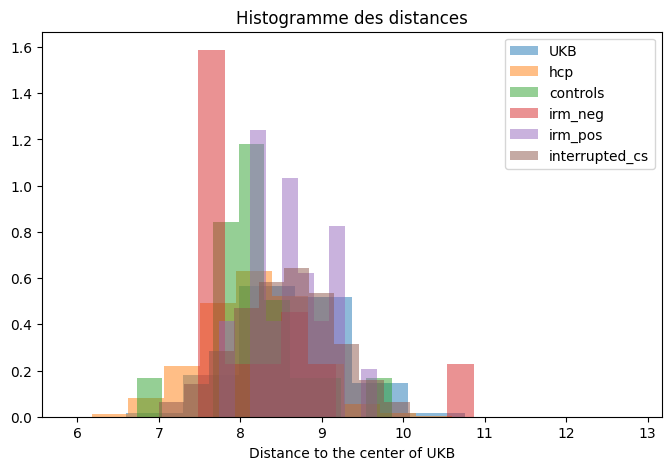

In [20]:
X_all = np.vstack([X_ukb, X_hcp, X_control, X_neg, X_pos, X_cs])
center = X_ukb.mean(axis=0)
distances = np.linalg.norm(X_all - center, axis=1)


labels = np.array(['UKB']*len(X_ukb) + ['hcp']*len(X_hcp)+ ['controls']*len(X_control)+ ['irm_neg']*len(X_neg)+ ['irm_pos']*len(X_pos)+ ['interrupted_cs']*len(X_cs))

plt.figure(figsize=(8,5))
plt.hist(distances[labels == 'UKB'], alpha=0.5, label='UKB', density=True)
plt.hist(distances[labels == 'hcp'], alpha=0.5, label='hcp', density=True)
plt.hist(distances[labels == 'controls'], alpha=0.5, label='controls', density=True)
plt.hist(distances[labels == 'irm_neg'], alpha=0.5, label='irm_neg', density=True)
plt.hist(distances[labels == 'irm_pos'], alpha=0.5, label='irm_pos', density=True)
plt.hist(distances[labels == 'interrupted_cs'], alpha=0.5, label='interrupted_cs', density=True)



plt.xlabel("Distance to the center of UKB")

plt.title("Histogramme des distances")
plt.legend()
plt.show()

Distance moyenne entre Datasets

In [21]:
import seaborn as sns

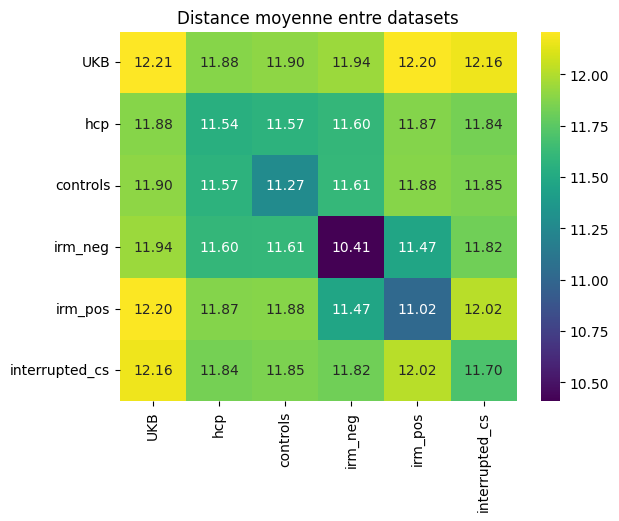

In [22]:
datasets=[X_ukb, X_hcp, X_control, X_neg, X_pos, X_cs]
labels = ['UKB','hcp','controls','irm_neg','irm_pos','interrupted_cs']

N = len(datasets)
dist_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        dist_matrix[i, j] = np.mean(cdist(datasets[i], datasets[j]))

sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap='viridis',
            xticklabels=labels, yticklabels=labels)
plt.title("Distance moyenne entre datasets")
plt.show()


Distance entre les datasets 

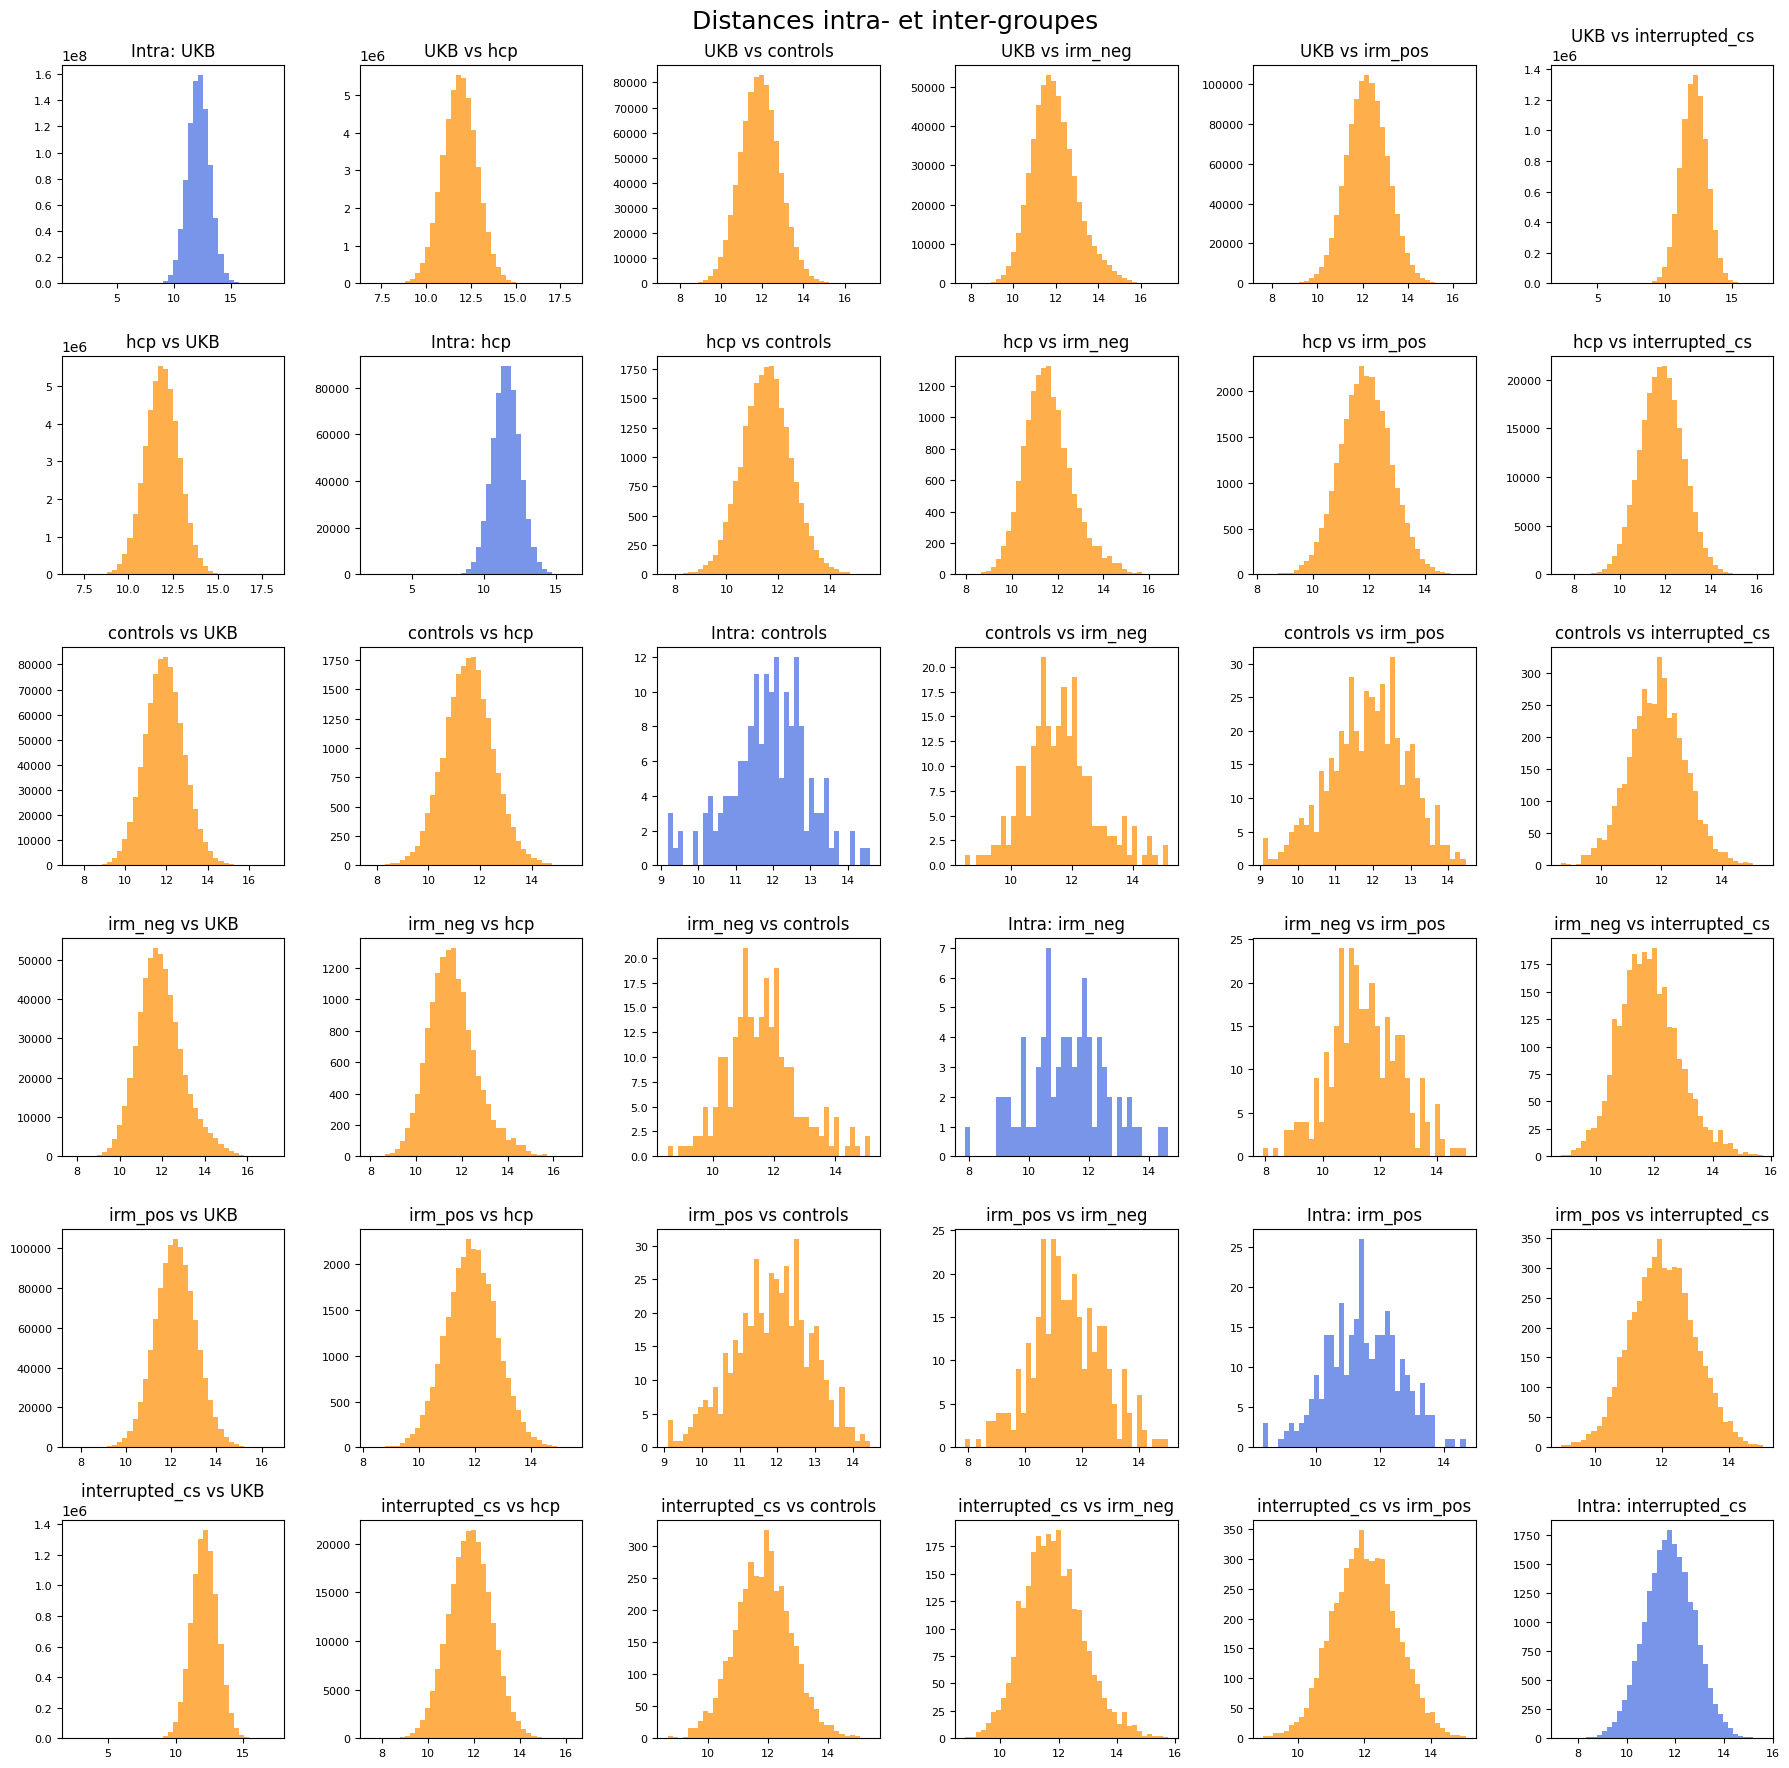

In [23]:
datasets = [np.asarray(X) for X in datasets]

n = len(datasets)

fig, axes = plt.subplots(n, n, figsize=(18, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        Xi, Xj = datasets[i], datasets[j]

        if i == j:
            # distances intra-groupe
            D = cdist(Xi, Xi)
            distances = D[np.triu_indices_from(D, k=1)]  # éviter doublons et diagonale
            ax.hist(distances, bins=40, color='royalblue', alpha=0.7)
            ax.set_title(f"Intra: {labels[i]}")
        else:
            # distances inter-groupe
            D = cdist(Xi, Xj)
            distances = D.flatten()
            ax.hist(distances, bins=40, color='darkorange', alpha=0.7)
            ax.set_title(f"{labels[i]} vs {labels[j]}")

        ax.tick_params(labelsize=8)

# Ajustement final
fig.suptitle("Distances intra- et inter-groupes", fontsize=18)
plt.tight_layout()
plt.show()